In [1]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BDeuScore, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

F:\MU_LAB\Conda\envs\bn_c\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
F:\MU_LAB\Conda\envs\bn_c\lib\site-packages\pgmpy\utils\utils.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
# Load Discretized Data
df = pd.read_csv('../data/processed/data_discretized_final2.csv')
print(f"Loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loaded: (30240, 14)
Columns: ['Motion_Intensity', 'Temporal_Smoothness', 'Luminance', 'HOG_features', 'HR', 'GSR', 'Left_Diameter', 'Right_Diameter', 'Left_Openness', 'Right_Openness', 'Gaze_Error_Angle', 'HRV', 'Eye_Blink_Rate', 'fms']


In [3]:
print(df['fms'].value_counts())

fms
1    18720
2     4020
3     3120
4     2160
7      960
6      660
5      600
Name: count, dtype: int64


In [4]:
print(df.columns.tolist())

['Motion_Intensity', 'Temporal_Smoothness', 'Luminance', 'HOG_features', 'HR', 'GSR', 'Left_Diameter', 'Right_Diameter', 'Left_Openness', 'Right_Openness', 'Gaze_Error_Angle', 'HRV', 'Eye_Blink_Rate', 'fms']


In [5]:
min_samples = df['fms'].value_counts().min() 
df_balanced = df.groupby('fms').apply(
    lambda x: x.sample(min_samples, replace=False, random_state=42)
).reset_index(drop=True)

print(f"Balanced: {df_balanced.shape}")  # Will be (4200, 11)
print(f"FMS distribution: {df_balanced['fms'].value_counts().sort_index().to_dict()}")

Balanced: (4200, 14)
FMS distribution: {1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600}


In [19]:
system_features = [
    'Motion_Intensity',
    'Temporal_Smoothness',
    'Luminance',
    'HOG_features'
]

physio_features = [
    'HR',
    'GSR',
    'Left_Diameter',
    'Right_Diameter',
    'Left_Openness',
    'Right_Openness',
    'Gaze_Error_Angle',
    'HRV',
    'Eye_Blink_Rate'
]

target = 'fms'

print(f"System features: {system_features}")
print(f"Physio features: {physio_features}")
print(f"Target: {target}")


all_features = system_features + physio_features + [target]
assert all(f in df_balanced.columns for f in all_features), "Column mismatch!"

System features: ['Motion_Intensity', 'Temporal_Smoothness', 'Luminance', 'HOG_features']
Physio features: ['HR', 'GSR', 'Left_Diameter', 'Right_Diameter', 'Left_Openness', 'Right_Openness', 'Gaze_Error_Angle', 'HRV', 'Eye_Blink_Rate']
Target: fms


In [18]:
# black_list = []

# for physio in physio_features:
#     for system in system_features:
#         black_list.append((physio, system))

# all_features = system_features + physio_features
# for feature in all_features:
#     black_list.append((target, feature))

# print(f"Black list edges: {len(black_list)}")
# print(f"\nExample forbidden edges:")
# for edge in black_list[:]:
#     print(f"  {edge[0]} → {edge[1]}: FORBIDDEN")

In [20]:
black_list = []

# 1. Physio features CANNOT cause System features
for physio in physio_features:
    for system in system_features:
        black_list.append((physio, system))

# 2. System features CANNOT cause other System features (NEW!)
for system1 in system_features:
    for system2 in system_features:
        if system1 != system2:  # Don't add self-loops
            black_list.append((system1, system2))

# 3. FMS (target) CANNOT cause anything
all_features = system_features + physio_features
for feature in all_features:
    black_list.append((target, feature))

print(f"Black list edges: {len(black_list)}")
print(f"\nExample forbidden edges:")
for edge in black_list[:10]:
    print(f"  {edge[0]} → {edge[1]}: FORBIDDEN")


Black list edges: 61

Example forbidden edges:
  HR → Motion_Intensity: FORBIDDEN
  HR → Temporal_Smoothness: FORBIDDEN
  HR → Luminance: FORBIDDEN
  HR → HOG_features: FORBIDDEN
  GSR → Motion_Intensity: FORBIDDEN
  GSR → Temporal_Smoothness: FORBIDDEN
  GSR → Luminance: FORBIDDEN
  GSR → HOG_features: FORBIDDEN
  Left_Diameter → Motion_Intensity: FORBIDDEN
  Left_Diameter → Temporal_Smoothness: FORBIDDEN


In [21]:
hc = HillClimbSearch(df_balanced)
best_model = hc.estimate(
    scoring_method=BDeuScore(df_balanced, equivalent_sample_size=5),
    max_indegree=3,
    black_list=black_list,
    show_progress=True
)

print(f"Edges: {len(best_model.edges())}")
for edge in list(best_model.edges())[:]:
    print(f"  {edge[0]} → {edge[1]}")

  0%|                                                                                 | 15/1000000 [00:02<37:15:02,  7.46it/s]

Edges: 15
  Motion_Intensity → Gaze_Error_Angle
  Luminance → Right_Diameter
  Luminance → Left_Diameter
  Luminance → fms
  Luminance → Eye_Blink_Rate
  GSR → fms
  GSR → HRV
  Left_Diameter → GSR
  Left_Diameter → Right_Diameter
  Right_Diameter → Right_Openness
  Right_Diameter → GSR
  Right_Openness → Eye_Blink_Rate
  Right_Openness → Left_Openness
  HRV → HR
  Eye_Blink_Rate → Left_Openness


In [22]:
def get_ancestors(model, node):
    ancestors = set()
    queue = [node]
    while queue:
        current = queue.pop(0)
        for parent in model.get_parents(current):
            if parent not in ancestors:
                ancestors.add(parent)
                queue.append(parent)
    return ancestors

ancestors_of_fms = get_ancestors(best_model, target)

nodes_to_keep = list(set(ancestors_of_fms) | set(system_features) | {target})

print(f"Ancestors of FMS: {len(ancestors_of_fms)}")
print(f"System features forced: {len(system_features)}")
print(f"Total nodes to keep: {len(nodes_to_keep)}")
print(f"\nNodes to keep:")
for node in sorted(nodes_to_keep):
    if node in system_features:
        marker = "[SYS]"
    elif node == target:
        marker = "[TGT]"
    else:
        marker = "[PHY]"
    print(f"  - {node} {marker}")


Ancestors of FMS: 4
System features forced: 4
Total nodes to keep: 8

Nodes to keep:
  - GSR [PHY]
  - HOG_features [SYS]
  - Left_Diameter [PHY]
  - Luminance [SYS]
  - Motion_Intensity [SYS]
  - Right_Diameter [PHY]
  - Temporal_Smoothness [SYS]
  - fms [TGT]


In [23]:
edges_to_keep = [e for e in best_model.edges() if e[0] in nodes_to_keep and e[1] in nodes_to_keep]
reduced_model = BayesianNetwork(edges_to_keep)

reduced_nodes = set(reduced_model.nodes())
isolated_features = [f for f in system_features if f not in reduced_nodes]

print(f"Edges from structure learning: {len(edges_to_keep)}")
print(f"Isolated system features: {isolated_features}")

for f in isolated_features:
    reduced_model.add_node(f)

manual_edges = []
for feature in isolated_features:
    manual_edges.append((feature, target))
    print(f"  Adding manual edge: {feature} → {target}")


for edge in manual_edges:
    reduced_model.add_edge(edge[0], edge[1])

print(f"\n Final reduced model:")
print(f"  Nodes: {len(reduced_model.nodes())}")
print(f"  Edges: {len(reduced_model.edges())}")
print(f"\nAll edges:")
for edge in reduced_model.edges():
    print(f"  {edge[0]} → {edge[1]}")


Edges from structure learning: 7
Isolated system features: ['Motion_Intensity', 'Temporal_Smoothness', 'HOG_features']
  Adding manual edge: Motion_Intensity → fms
  Adding manual edge: Temporal_Smoothness → fms
  Adding manual edge: HOG_features → fms

 Final reduced model:
  Nodes: 8
  Edges: 10

All edges:
  Luminance → Right_Diameter
  Luminance → Left_Diameter
  Luminance → fms
  Right_Diameter → GSR
  Left_Diameter → GSR
  Left_Diameter → Right_Diameter
  GSR → fms
  Motion_Intensity → fms
  Temporal_Smoothness → fms
  HOG_features → fms


In [24]:
print("DataFrame columns:")
print(df_balanced.columns.tolist())

print("\nModel nodes:")
print(list(reduced_model.nodes()))


DataFrame columns:
['Motion_Intensity', 'Temporal_Smoothness', 'Luminance', 'HOG_features', 'HR', 'GSR', 'Left_Diameter', 'Right_Diameter', 'Left_Openness', 'Right_Openness', 'Gaze_Error_Angle', 'HRV', 'Eye_Blink_Rate', 'fms']

Model nodes:
['Luminance', 'Right_Diameter', 'Left_Diameter', 'fms', 'GSR', 'Motion_Intensity', 'Temporal_Smoothness', 'HOG_features']


In [25]:
reduced_model.fit(
    df_balanced[list(reduced_model.nodes())],
    estimator=BayesianEstimator,
    prior_type='BDeu',
    equivalent_sample_size=5
)

print(f"CPTs created: {len(reduced_model.get_cpds())}")

assert reduced_model.check_model(), "Model invalid!"


CPTs created: 8


In [26]:
print("\nSample CPT (FMS):")
fms_cpd = reduced_model.get_cpds(target)
print(fms_cpd)

assert reduced_model.check_model(), "Model invalid!"


Sample CPT (FMS):
+---------------------+------------------------+-----+------------------------+------------------------+
| GSR                 | GSR(1)                 | ... | GSR(5)                 | GSR(5)                 |
+---------------------+------------------------+-----+------------------------+------------------------+
| HOG_features        | HOG_features(1)        | ... | HOG_features(5)        | HOG_features(5)        |
+---------------------+------------------------+-----+------------------------+------------------------+
| Luminance           | Luminance(1)           | ... | Luminance(5)           | Luminance(5)           |
+---------------------+------------------------+-----+------------------------+------------------------+
| Motion_Intensity    | Motion_Intensity(1)    | ... | Motion_Intensity(5)    | Motion_Intensity(5)    |
+---------------------+------------------------+-----+------------------------+------------------------+
| Temporal_Smoothness | Temporal_Smo

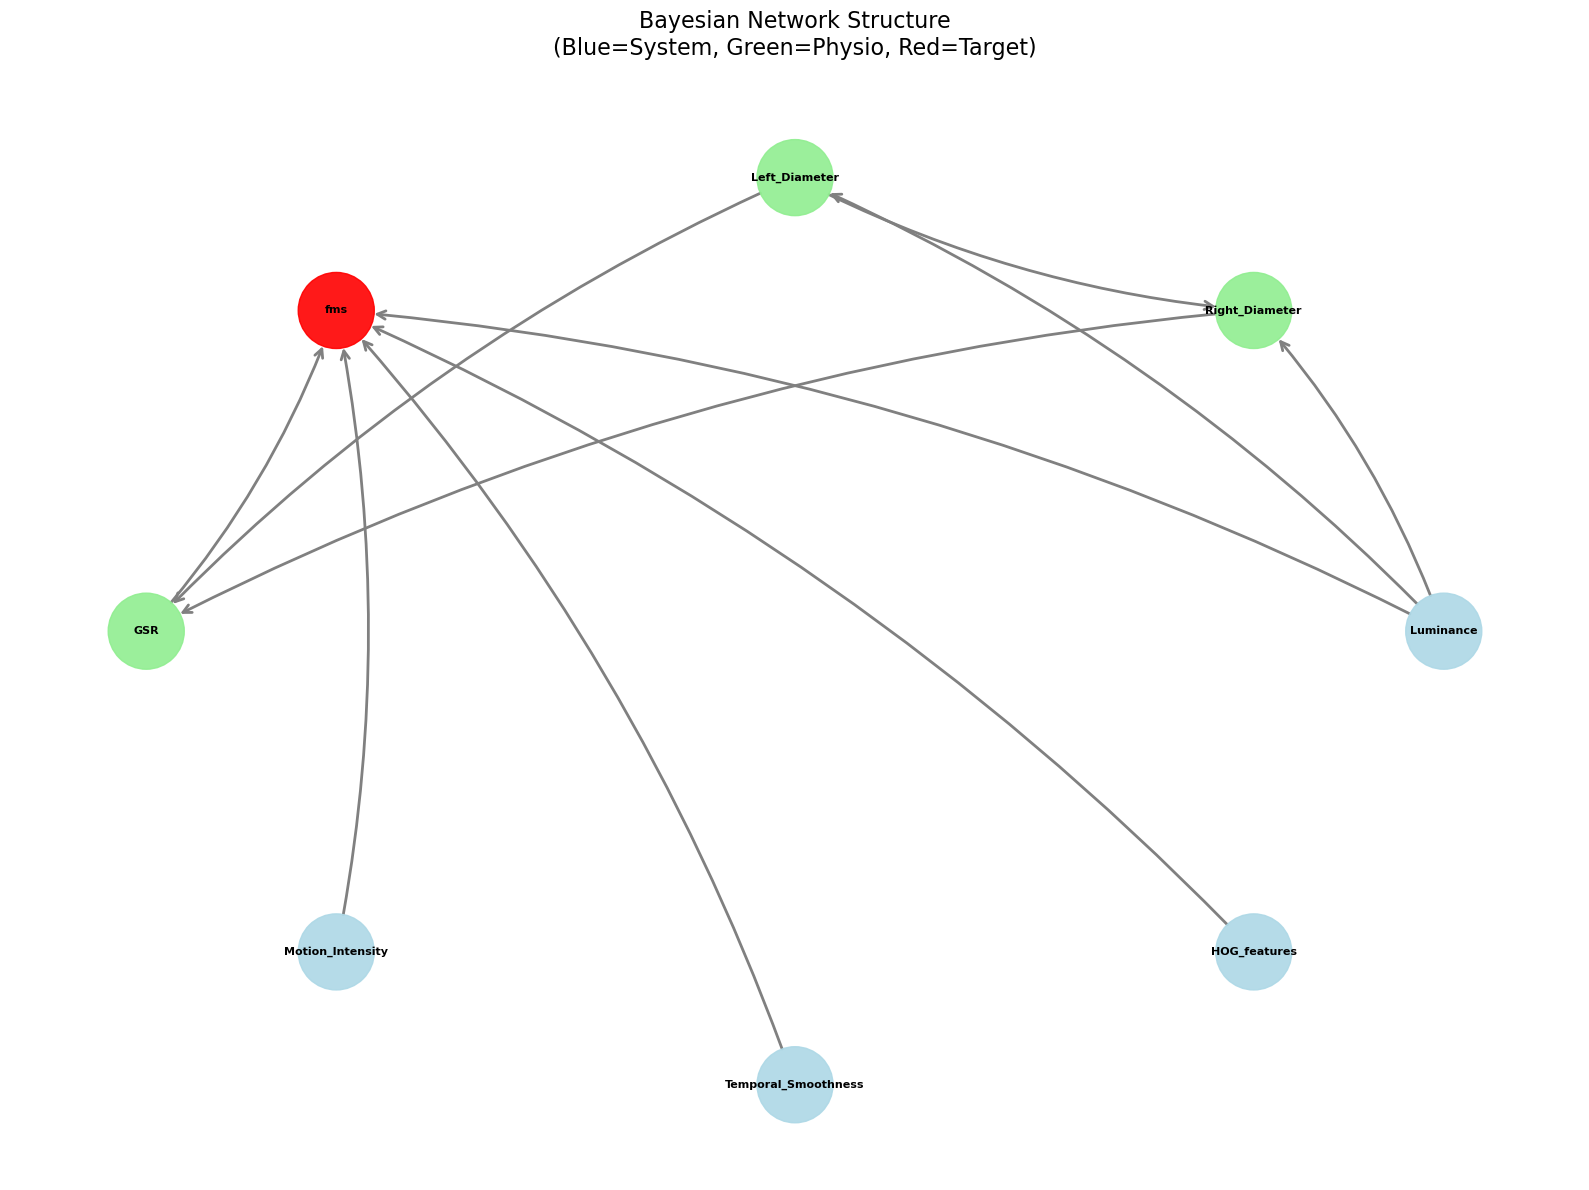

 Saved: bn_structure.png


In [27]:
# Visualize DAG

plt.figure(figsize=(16, 12))

try:
    pos = nx.kamada_kawai_layout(reduced_model)
except:
    pos = nx.spring_layout(reduced_model, k=2, iterations=50, seed=42)

node_colors = []
for node in reduced_model.nodes():
    if node == target:
        node_colors.append('red')
    elif node in system_features:
        node_colors.append('lightblue')
    else:
        node_colors.append('lightgreen')

nx.draw_networkx_nodes(reduced_model, pos, 
                       node_color=node_colors,
                       node_size=3000,
                       alpha=0.9)

nx.draw_networkx_labels(reduced_model, pos,
                        font_size=8,
                        font_weight='bold')

nx.draw_networkx_edges(reduced_model, pos,
                       arrows=True,
                       arrowstyle='->',
                       arrowsize=15,
                       edge_color='gray',
                       width=2,
                       connectionstyle='arc3,rad=0.1',  # Curved edges
                       node_size=3000)  # Important: match node size

plt.title('Bayesian Network Structure\n(Blue=System, Green=Physio, Red=Target)', 
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()

# Save
plt.savefig('../data/results/bn_structure_2.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: bn_structure.png")

In [28]:
with open('../models/bn_trained_final2.pkl', 'wb') as f:
    pickle.dump(reduced_model, f)

print(f"  Nodes: {len(reduced_model.nodes())}")
print(f"  Edges: {len(reduced_model.edges())}")
print(f"  Training samples: {len(df_balanced)}")


  Nodes: 8
  Edges: 10
  Training samples: 4200


In [29]:
print(f"\nNodes: {len(reduced_model.nodes())}")
print(f"Edges: {len(reduced_model.edges())}")

print("\n--- EDGES ---")
for i, (parent, child) in enumerate(sorted(reduced_model.edges()), 1):
    print(f"{i:2d}. {parent:25} → {child}")

print("\n--- NODE PARENTS ---")
for node in sorted(reduced_model.nodes()):
    parents = list(reduced_model.get_parents(node))
    if parents:
        print(f"{node:20} ← {', '.join(parents)}")
    else:
        print(f"{node:20} (root node)")



Nodes: 8
Edges: 10

--- EDGES ---
 1. GSR                       → fms
 2. HOG_features              → fms
 3. Left_Diameter             → GSR
 4. Left_Diameter             → Right_Diameter
 5. Luminance                 → Left_Diameter
 6. Luminance                 → Right_Diameter
 7. Luminance                 → fms
 8. Motion_Intensity          → fms
 9. Right_Diameter            → GSR
10. Temporal_Smoothness       → fms

--- NODE PARENTS ---
GSR                  ← Left_Diameter, Right_Diameter
HOG_features         (root node)
Left_Diameter        ← Luminance
Luminance            (root node)
Motion_Intensity     (root node)
Right_Diameter       ← Luminance, Left_Diameter
Temporal_Smoothness  (root node)
fms                  ← Luminance, GSR, Motion_Intensity, Temporal_Smoothness, HOG_features


In [30]:
with open('../models/bn_trained_final2.pkl', 'wb') as f:
    pickle.dump(reduced_model, f)

print(f"\nModel summary:")
print(f"  Nodes: {len(reduced_model.nodes())}")
print(f"  Edges: {len(reduced_model.edges())}")
print(f"  CPTs: {len(reduced_model.get_cpds())}")
print(f"  Max parents: {max(len(reduced_model.get_parents(n)) for n in reduced_model.nodes())}")


Model summary:
  Nodes: 8
  Edges: 10
  CPTs: 8
  Max parents: 5
